## Manuscript figures 

Notebook generates figures 3-10 and tables 4-6 in Krell et al. (2021) Water Resources Research.

In [1]:
## Import packages
## We need to add the module path to our system path so 
## so that our notebook can find our local objects and code:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
     
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
from math import exp
import seaborn as sns
import sys
import glob
from dateutil.relativedelta import *
from numpy.random import exponential, uniform
import scipy.stats as st
from statistics import mean

# Import objects
from farm import Climate
from farm import Soil
from farm import Crop
from farm import StaticCrop
from farm import CropModel
from farm.functions import *
from farm.climate import make_climate_parameters, check_exponential, Climate

from exponential_model.functions import *
# Set background color
# plot.rc['figure.facecolor'] = 'white'
# plot.rc.axesfacecolor = 'white'

In [3]:
## Figure 4. Time series of T, E, and E+T

# Set OL JOGI climatology for the following figures
station = 'OL JOGI FARM'
interval='dekad'
data_file="../data/CETRAD/CETRAD_rainfall.csv"
texture='clay loam'

#TODO: create input rainfall using generate
a_mid, l_mid, sd = make_climate_parameters(data_file = data_file, station=station, interval=interval) 


# Make a dataframe with these alphas and lambdas
df_mid = pd.DataFrame({'alpha':a_mid, 'lambda':l_mid, 'dekad':np.arange(1,38,1),'doy':['10','20','30','40',
                                                                           '50','60','70','80','90','100',
                                                                            '110','120','130','140','150','160',
                                                                             '170','180','190','200','210','220',
                                                                             '230','240','250','260','270','280','290',
                                                                              '300','310','320','330','340','350','360','365'
                                                                              ]})

def run_tau_models(ET_max=0.5, kc=0.1):

    ### Crop model ###
    climate = Climate(
            data_file=data_file,
            station=station,
            interval=interval,
            alpha_r = a_mid,
            lambda_r = l_mid,
            ET_max = ET_max,
            do_std=False)
        
    soil = Soil(texture)
    # crop0 = Crop()
    crop = StaticCrop(soil=soil, const_kc=const_kc)
    soil.set_nZr(crop)  
    model = CropModel(crop=crop,soil=soil,climate=climate)

    #TODO: Add warm-up period
    model.run()

    # Set saturation variable
    s = np.arange(0, 1, 0.0056) #saturation

    # Convert to vwc
    vwc = s*Soil(texture).n 

    output = model.output()

    ### Drydown detection ###

    precip_thresh = 2
    # Any positive increment smaller than 5% of the observed range of soil moisture at the site is excluded if it would otherwise truncate a drydown. 
    dSdt_noise_thresh = 0.01 #(output.s.max() - output.s.min()) * 0.05
    # To avoid noise creating spurious drydowns, identified drydowns were excluded from the analysis when the positive increment preceding the drydown was less than two times the target unbiased root-mean-square difference for SMAP observations (0.08).
    dSdt_positive_thresh = 0
    
    drydown_events = calc_dSdt(cropmodel_output=output, precip_thresh=precip_thresh, dSdt_positive_thresh=dSdt_positive_thresh, dSdt_noise_thresh=dSdt_noise_thresh, plot_results=False)

    min_s = output.s.min()
    drydown_params = []

    ### Exp fits  ###
    for i, event in drydown_events.iterrows():
        fit_param = fit_exp_model(event, min_sm_values_at_the_pt=min_s)
        drydown_params.append(fit_param)

    df_drydown_params = pd.DataFrame(drydown_params)

    ### Export ###
    drydown_and_params = pd.merge(drydown_events, df_drydown_params.drop(columns='delta_theta'), on=['event_start', 'event_end'], how='outer')
    drydown_and_params.to_csv(r'..\output\ryoko_debug\test.csv')

    return drydown_and_params


In [4]:
ET_max_range = np.arange(0, 8+1, 1)
LAI_range = np.arange(2, 4.5, 0.3125)
kc_range = np.arange(0, 1.1, 0.1375)
# kc_range
# ET_max = 7.0
# const_kc = 0.5

In [5]:
import warnings
warnings.filterwarnings("ignore")
ds_drydown_and_params = pd.DataFrame()
for i, ET_max in enumerate(ET_max_range):
    for j, const_kc in enumerate(kc_range):
        print(f"Index: ({i}, {j}), ET_max: {ET_max}, const_kc: {const_kc}")
        try:
            drydown_and_params = run_tau_models(ET_max=ET_max, kc=const_kc)
            drydown_and_params['ET_max'] = ET_max
            ds_drydown_and_params = pd.concat([ds_drydown_and_params, drydown_and_params])
        except:
            continue
    ds_drydown_and_params = ds_drydown_and_params.sort_index()

Index: (0, 0), ET_max: 0, const_kc: 0.0
Laikipia station data was inputted.
Index: (0, 1), ET_max: 0, const_kc: 0.1375


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (0, 2), ET_max: 0, const_kc: 0.275


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (0, 3), ET_max: 0, const_kc: 0.41250000000000003


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (0, 4), ET_max: 0, const_kc: 0.55


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (0, 5), ET_max: 0, const_kc: 0.6875


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (0, 6), ET_max: 0, const_kc: 0.8250000000000001


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (0, 7), ET_max: 0, const_kc: 0.9625000000000001


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (1, 0), ET_max: 1, const_kc: 0.0


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (1, 1), ET_max: 1, const_kc: 0.1375


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (1, 2), ET_max: 1, const_kc: 0.275


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (1, 3), ET_max: 1, const_kc: 0.41250000000000003


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Index: (1, 4), ET_max: 1, const_kc: 0.55
Laikipia station data was inputted.
Index: (1, 5), ET_max: 1, const_kc: 0.6875


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (1, 6), ET_max: 1, const_kc: 0.8250000000000001


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (1, 7), ET_max: 1, const_kc: 0.9625000000000001


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (2, 0), ET_max: 2, const_kc: 0.0


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (2, 1), ET_max: 2, const_kc: 0.1375


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (2, 2), ET_max: 2, const_kc: 0.275


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Index: (2, 3), ET_max: 2, const_kc: 0.41250000000000003
Laikipia station data was inputted.
Index: (2, 4), ET_max: 2, const_kc: 0.55


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (2, 5), ET_max: 2, const_kc: 0.6875


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (2, 6), ET_max: 2, const_kc: 0.8250000000000001


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (2, 7), ET_max: 2, const_kc: 0.9625000000000001


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (3, 0), ET_max: 3, const_kc: 0.0


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (3, 1), ET_max: 3, const_kc: 0.1375


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (3, 2), ET_max: 3, const_kc: 0.275


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (3, 3), ET_max: 3, const_kc: 0.41250000000000003


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (3, 4), ET_max: 3, const_kc: 0.55


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (3, 5), ET_max: 3, const_kc: 0.6875


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (3, 6), ET_max: 3, const_kc: 0.8250000000000001


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (3, 7), ET_max: 3, const_kc: 0.9625000000000001


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (4, 0), ET_max: 4, const_kc: 0.0


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (4, 1), ET_max: 4, const_kc: 0.1375


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (4, 2), ET_max: 4, const_kc: 0.275


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (4, 3), ET_max: 4, const_kc: 0.41250000000000003


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (4, 4), ET_max: 4, const_kc: 0.55


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (4, 5), ET_max: 4, const_kc: 0.6875


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (4, 6), ET_max: 4, const_kc: 0.8250000000000001


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (4, 7), ET_max: 4, const_kc: 0.9625000000000001


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (5, 0), ET_max: 5, const_kc: 0.0


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (5, 1), ET_max: 5, const_kc: 0.1375


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (5, 2), ET_max: 5, const_kc: 0.275


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (5, 3), ET_max: 5, const_kc: 0.41250000000000003


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (5, 4), ET_max: 5, const_kc: 0.55


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (5, 5), ET_max: 5, const_kc: 0.6875


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (5, 6), ET_max: 5, const_kc: 0.8250000000000001


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (5, 7), ET_max: 5, const_kc: 0.9625000000000001


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (6, 0), ET_max: 6, const_kc: 0.0


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (6, 1), ET_max: 6, const_kc: 0.1375


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (6, 2), ET_max: 6, const_kc: 0.275


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (6, 3), ET_max: 6, const_kc: 0.41250000000000003


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (6, 4), ET_max: 6, const_kc: 0.55


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (6, 5), ET_max: 6, const_kc: 0.6875


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (6, 6), ET_max: 6, const_kc: 0.8250000000000001


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (6, 7), ET_max: 6, const_kc: 0.9625000000000001


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (7, 0), ET_max: 7, const_kc: 0.0


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (7, 1), ET_max: 7, const_kc: 0.1375


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (7, 2), ET_max: 7, const_kc: 0.275


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Index: (7, 3), ET_max: 7, const_kc: 0.41250000000000003
Laikipia station data was inputted.
Index: (7, 4), ET_max: 7, const_kc: 0.55


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (7, 5), ET_max: 7, const_kc: 0.6875


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (7, 6), ET_max: 7, const_kc: 0.8250000000000001


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (7, 7), ET_max: 7, const_kc: 0.9625000000000001


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (8, 0), ET_max: 8, const_kc: 0.0


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (8, 1), ET_max: 8, const_kc: 0.1375


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (8, 2), ET_max: 8, const_kc: 0.275


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (8, 3), ET_max: 8, const_kc: 0.41250000000000003


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (8, 4), ET_max: 8, const_kc: 0.55


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (8, 5), ET_max: 8, const_kc: 0.6875


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (8, 6), ET_max: 8, const_kc: 0.8250000000000001


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.
Index: (8, 7), ET_max: 8, const_kc: 0.9625000000000001


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


Laikipia station data was inputted.


g:\Araki\maize-Toff\exponential_model\functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropmodel_output['dSdt(t-1)'] = cropmodel_output.dSdt.shift(+1)


In [6]:
ds_drydown_and_params.head()

,event_start,event_end,soil_moisture,precip,delta_theta,LAI,ET,theta_w,tau,r_squared,opt_drydown,ET_max
0,39,49,"[0.565560107976778, 0.565149224376206, 0.56474...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.218483,"[0.34375, 0.34375, 0.34375, 0.34375, 0.34375, ...","[0.07823223754891159, 0.07732829362765305, 0.0...",0.557894,14.694109,0.993760,"[0.5656961370141735, 0.5651828333116902, 0.564...",0
0,65,73,"[0.559557762792462, 0.5588747052489388, 0.5582...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.049227,"[0.6875, 0.6875, 0.6875, 0.6875, 0.6875, 0.687...","[0.1300541562868329, 0.12704870309533053, 0.12...",0.549827,11.412696,0.994688,"[0.5597104739189719, 0.5588812997206808, 0.558...",0
0,54,60,"[0.6156689755948652, 0.6087398672746923, 0.602...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.014329,"[2.4062500000000004, 2.4062500000000004, 2.406...","[1.3193022241609242, 1.2125939560302614, 1.114...",0.547976,8.708655,0.999307,"[0.6160140832598452, 0.6086332402939505, 0.602...",0
0,32,40,"[0.45404204945636134, 0.45399720238783486, 0.4...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.086795,"[2.4062500000000004, 2.4062500000000004, 2.406...","[0.008538881847437297, 0.008522013694299875, 0...",0.453164,243.405579,0.124393,"[0.4538734835508075, 0.45387057587496477, 0.45...",2
0,45,61,"[0.6579784039588498, 0.6482467418219354, 0.639...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.7572025728788...",0.096603,"[1.71875, 1.71875, 1.71875, 1.71875, 1.71875, ...","[1.8529084708684918, 1.7188362001718975, 1.594...",0.521032,13.657949,0.999995,"[0.6578916770862091, 0.6482292172045798, 0.639...",4


Text(0, 0.5, 'LAI [-]')

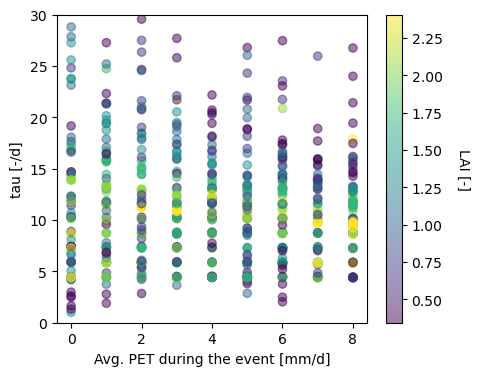

In [30]:
ds_drydown_and_params['mean_LAI'] = ds_drydown_and_params['LAI'].apply(np.mean)
# drydown_and_params['mean_ET'] = drydown_and_params['ET'].apply(len)
fig, ax = plt.subplots(1,1, figsize=(5, 4))
sc = ax.scatter(ds_drydown_and_params['ET_max'], ds_drydown_and_params['tau'], c=ds_drydown_and_params['mean_LAI'], alpha=0.5)
ax.set_xlabel('Avg. PET during the event [mm/d]')
ax.set_ylabel('tau [-/d]')
ax.set_ylim([0, 30])
cbar = fig.colorbar(sc)
cbar.ax.set_ylabel('LAI [-]', rotation=270, labelpad=20)

Text(0.5, 0, 'LAI')

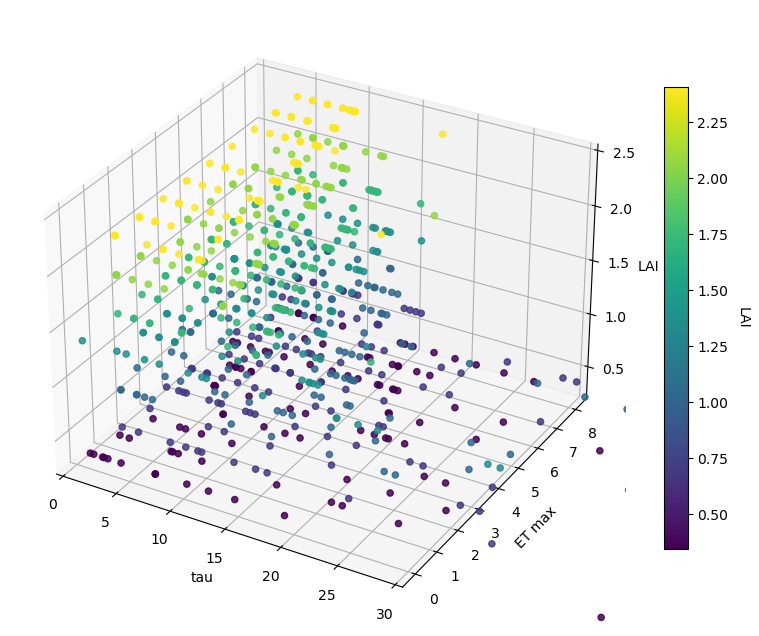

In [37]:
fig = plt.figure(figsize=(8, 8), tight_layout=True)
ax4 =  fig.add_subplot(projection='3d')

# Data for a three-dimensional line
scatter = ax4.scatter3D(ds_drydown_and_params['tau'], ds_drydown_and_params['ET_max'], ds_drydown_and_params['mean_LAI'], c= ds_drydown_and_params['mean_LAI'])
cbar = plt.colorbar(scatter, ax=ax4, shrink=0.6)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('LAI', rotation=270)
ax4.set_xlabel('tau')
ax4.set_xlim([0, 30])
ax4.set_ylabel('ET max')
ax4.set_zlabel('LAI')


In [34]:
ds_drydown_and_params['tau']

0      14.694109
0      11.412696
0       8.708655
0     243.405579
0      13.657949
         ...    
24      5.217578
24    135.155028
25     17.460222
25     30.978836
25     27.503051
Name: tau, Length: 914, dtype: float64

ValueError: Argument Z must be 2-dimensional.

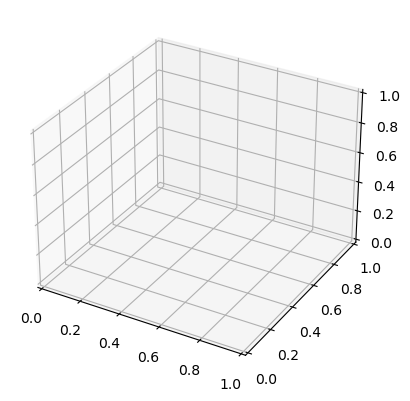

In [23]:
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# surf = ax.plot_surface(ds_drydown_and_params['tau'], ds_drydown_and_params['ET_max'], ds_drydown_and_params['mean_LAI'], 
#                        linewidth=0, antialiased=False)